<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 6.33 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 13:51:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 9.2 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 133 kB 50.9 MB/s 
     |████████████████████████████████| 138 kB 51.1 MB/s 
     |████████████████████████████████| 170 kB 52.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 748 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 144fmybl
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/144fmybl


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: pgfvtnl8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
31/31 [==============================] - 31s 90ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1343 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0619
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0360 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0471
Epoch 3/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0294 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0471
Epoch 4/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0301 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0503
Epoch 5/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0020 - mean_squared_erro

epoch,49
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02165
val_loss,0.00282
val_mean_squared_error,0.00282
val_mean_absolute_error,0.03934
_runtime,68
_timestamp,1626789258
_step,49
best_val_loss,0.00279


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂▃▅▃▅▄▂▄▂▂▄▃▂█▂▂▄▃▂▁▂▇▅▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▂▂▃▅▃▅▄▂▄▂▂▄▃▂█▂▂▄▃▂▁▂▇▅▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▃▃▃▆▄▅▄▂▄▂▂▄▃▃█▂▂▅▃▂▁▂█▆▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v9s8gybt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 30s 469ms/step - loss: 0.0827 - mean_squared_error: 0.0827 - mean_absolute_error: 0.1765 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1089
Epoch 2/50
31/31 [==============================] - 13s 403ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0311 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0531
Epoch 3/50
31/31 [==============================] - 11s 367ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0266 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0908
Epoch 4/50
31/31 [==============================] - 13s 409ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0247 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0474
Epoch 5/50
31/31 [==============================] - 12s 400ms/step - loss: 0.0021 - mean_squ

epoch,49
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01549
val_loss,0.00491
val_mean_squared_error,0.00491
val_mean_absolute_error,0.05788
_runtime,645
_timestamp,1626789916
_step,49
best_val_loss,0.00316


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▂▅▂▃▂▁▃▁▂▁▁▃▂▄▁▁█▃▁▂▂▁▁▂▁▁▁▁▅▁▁▁▂▂▂▁▁▁▂
val_mean_squared_error,▇▂▅▂▃▂▁▃▁▂▁▁▃▂▄▁▁█▃▁▂▂▁▁▂▁▁▁▁▅▁▁▁▂▂▂▁▁▁▂
val_mean_absolute_error,▇▂▅▂▃▃▁▄▂▃▁▂▄▂▄▂▂█▄▁▂▂▁▂▂▁▂▁▂▆▁▂▂▂▃▂▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kx5e1sou with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 24s 458ms/step - loss: 0.0938 - mean_squared_error: 0.0938 - mean_absolute_error: 0.1915 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0711
Epoch 2/50
31/31 [==============================] - 12s 394ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0361 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0638
Epoch 3/50
31/31 [==============================] - 12s 392ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0315 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0508
Epoch 4/50
31/31 [==============================] - 13s 407ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0290 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0737
Epoch 5/50
31/31 [==============================] - 12s 387ms/step - loss: 0.0023 - mean_squ

epoch,25
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.01879
val_loss,0.00989
val_mean_squared_error,0.00989
val_mean_absolute_error,0.08552
_runtime,336
_timestamp,1626790315
_step,25
best_val_loss,0.00426


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▂▅▃▃▁▁▁▁▁▂▂▁▁█▂▂▃▁▂▂▁▂▂
val_mean_squared_error,▂▁▁▂▅▃▃▁▁▁▁▁▂▂▁▁█▂▂▃▁▂▂▁▂▂
val_mean_absolute_error,▃▂▁▃▆▄▄▁▂▁▁▂▃▃▂▁█▃▃▄▁▃▃▁▃▃
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: t3sckc0i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 13s 94ms/step - loss: 0.0683 - mean_squared_error: 0.0683 - mean_absolute_error: 0.1534 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0749
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0245 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0623
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0316 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0603
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0257 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0509
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0016 - mean_squared

epoch,88
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.01853
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03796
_runtime,81
_timestamp,1626790463
_step,88
best_val_loss,0.0023


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▃▄▂▂▆▂▃▃▂▂█▂▁▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▃▂▁▁▁▁▁▁▂▁
val_mean_squared_error,▅▃▃▄▂▂▆▂▃▃▂▂█▂▁▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▃▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,▅▄▃▄▃▂▆▂▄▃▂▂█▂▂▃▁▂▂▁▂▂▂▃▂▂▂▁▂▁▃▃▁▂▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sieztohc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 24s 487ms/step - loss: 0.0881 - mean_squared_error: 0.0881 - mean_absolute_error: 0.2009 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0801
Epoch 2/50
31/31 [==============================] - 12s 396ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0764 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1100
Epoch 3/50
31/31 [==============================] - 12s 398ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0695 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0922
Epoch 4/50
31/31 [==============================] - 12s 400ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0611 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0810
Epoch 5/50
31/31 [==============================] - 12s 398ms/step - loss: 0.0056 - mean_squ

epoch,45
loss,0.00169
mean_squared_error,0.00169
mean_absolute_error,0.02727
val_loss,0.00266
val_mean_squared_error,0.00266
val_mean_absolute_error,0.03741
_runtime,592
_timestamp,1626791063
_step,45
best_val_loss,0.00225


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▃▂▂▂▃▇▂▂▂▁▁▁█▇▁▂▁▁▁▁▄▁▅▃▁▁▂▁▂▁▁▁▁▁▃▁▁▁
val_mean_squared_error,▂▃▃▂▂▂▃▇▂▂▂▁▁▁█▇▁▂▁▁▁▁▄▁▅▃▁▁▂▁▂▁▁▁▁▁▃▁▁▁
val_mean_absolute_error,▃▄▄▃▃▂▄▇▃▂▃▁▁▂█▇▁▃▁▁▁▁▅▁▆▄▁▂▂▁▂▁▂▁▁▁▃▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: hkfyfajh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 17s 546ms/step - loss: 0.2119 - mean_squared_error: 0.2119 - mean_absolute_error: 0.3008 - val_loss: 0.2987 - val_mean_squared_error: 0.2987 - val_mean_absolute_error: 0.5092
Epoch 2/100
16/16 [==============================] - 7s 409ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1179 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1045
Epoch 3/100
16/16 [==============================] - 7s 422ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0749 - val_loss: 0.2478 - val_mean_squared_error: 0.2478 - val_mean_absolute_error: 0.4627
Epoch 4/100
16/16 [==============================] - 6s 403ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1005 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1087
Epoch 5/100
16/16 [==============================] - 6s 398ms/step - loss: 0.0122 - mean_sq

epoch,32
loss,0.00287
mean_squared_error,0.00287
mean_absolute_error,0.0361
val_loss,0.02214
val_mean_squared_error,0.02214
val_mean_absolute_error,0.13523
_runtime,229
_timestamp,1626791299
_step,32
best_val_loss,0.00424


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▇▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▁▇▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▂▇▂▃▂▂▂▂▂▁▁▁▁▁▁▁▄▃▂▃▁▁▁▁▁▁▂▂▂▃▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 0i2xcko5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 13s 90ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.0885 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1518
Epoch 2/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0342 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0679
Epoch 3/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0312 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0484
Epoch 4/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0308 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0770
Epoch 5/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0047 - mean_squared

epoch,77
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02006
val_loss,0.01459
val_mean_squared_error,0.01459
val_mean_absolute_error,0.10898
_runtime,74
_timestamp,1626791382
_step,77
best_val_loss,0.002


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▂▂▂▁▁▁▂▁▁▁▂▂▂▁
val_loss,█▂▃▁▁▁▂▃▁▂▁▂▁▁▁▃▁▁▄▁▁▁▁▃▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▄
val_mean_squared_error,█▂▃▁▁▁▂▃▁▂▁▂▁▁▁▃▁▁▄▁▁▁▁▃▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▄
val_mean_absolute_error,█▃▄▂▂▂▂▃▁▃▁▃▂▁▂▄▁▁▅▁▂▁▂▄▁▂▁▁▁▂▁▁▁▃▁▂▁▁▁▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 782lj2b7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 12s 278ms/step - loss: 0.1050 - mean_squared_error: 0.1050 - mean_absolute_error: 0.2131 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0473
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.0860 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.1011
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0707 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0479
Epoch 4/50
8/8 [==============================] - 0s 33ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0417 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0447
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0048 - mean_squared_error: 0.0048

epoch,18
loss,0.00484
mean_squared_error,0.00484
mean_absolute_error,0.04516
val_loss,0.02107
val_mean_squared_error,0.02107
val_mean_absolute_error,0.13074
_runtime,21
_timestamp,1626791412
_step,18
best_val_loss,0.00358


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▄▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▁▂▃▂▂▂▂▃▂▂▁▂▁▂▂▂
val_loss,▁▂▁▁▁▂▁▂▁█▂▄▁▁▂▁▁▃▃
val_mean_squared_error,▁▂▁▁▁▂▁▂▁█▂▄▁▁▂▁▁▃▃
val_mean_absolute_error,▁▃▁▁▂▂▁▂▁█▃▅▂▂▃▁▁▄▄
_runtime,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
_timestamp,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆███
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: x9fvglj4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 11s 144ms/step - loss: 0.0769 - mean_squared_error: 0.0769 - mean_absolute_error: 0.1799 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1233
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0548 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0604
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0356 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0478
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0269 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0491
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0019 - mean_squared_err

epoch,26
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.0213
val_loss,0.00384
val_mean_squared_error,0.00384
val_mean_absolute_error,0.04329
_runtime,25
_timestamp,1626791446
_step,26
best_val_loss,0.00382


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▄▂▂▁▂▂▁▁▂▁
_runtime,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 31l4n743 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 15s 798ms/step - loss: 0.0774 - mean_squared_error: 0.0774 - mean_absolute_error: 0.1853 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0588
Epoch 2/200
8/8 [==============================] - 3s 398ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0673 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1480
Epoch 3/200
8/8 [==============================] - 3s 422ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0474 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1641
Epoch 4/200
8/8 [==============================] - 3s 411ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0526 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0587
Epoch 5/200
8/8 [==============================] - 3s 412ms/step - loss: 0.0066 - mean_squared_erro

epoch,35
loss,0.00337
mean_squared_error,0.00337
mean_absolute_error,0.03804
val_loss,0.00461
val_mean_squared_error,0.00461
val_mean_absolute_error,0.05086
_runtime,135
_timestamp,1626791590
_step,35
best_val_loss,0.00448


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
mean_squared_error,█▂▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
mean_absolute_error,█▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▂▁▂▂▁▂▁▁▂▂
val_loss,▁▆▇▁▃▅▁▂▂▂▁▁▂▄▂▁▂▂▂█▁▃▁▁▄▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▁▆▇▁▃▅▁▂▂▂▁▁▂▄▂▁▂▂▂█▁▃▁▁▄▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▂▆▇▂▄▆▂▂▂▂▁▁▃▅▃▁▃▃▂█▁▄▁▁▅▁▁▂▁▂▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l4bfqetp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 17s 531ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - mean_absolute_error: 0.1953 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1577
Epoch 2/200
16/16 [==============================] - 7s 417ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0788 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0744
Epoch 3/200
16/16 [==============================] - 7s 416ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0512 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0855
Epoch 4/200
16/16 [==============================] - 7s 414ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0395 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0571
Epoch 5/200
16/16 [==============================] - 6s 405ms/step - loss: 0.0026 - mean_sq

epoch,21
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02198
val_loss,0.01277
val_mean_squared_error,0.01277
val_mean_absolute_error,0.09921
_runtime,158
_timestamp,1626791776
_step,21
best_val_loss,0.00481


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▂▂▁▃▃▁▃▂▃▃▁▂▃▃▅▃
val_mean_squared_error,█▂▂▁▁▁▂▂▁▃▃▁▃▂▃▃▁▂▃▃▅▃
val_mean_absolute_error,█▂▃▁▁▂▃▃▂▄▄▁▄▂▄▄▂▃▃▄▅▄
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x0yejyb1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 11s 84ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1404 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0473
Epoch 2/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0313 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0502
Epoch 3/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0216 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0480
Epoch 4/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0197 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0550
Epoch 5/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0013 - mean_squared_erro

epoch,49
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.0171
val_loss,0.00247
val_mean_squared_error,0.00247
val_mean_absolute_error,0.03616
_runtime,47
_timestamp,1626791897
_step,49
best_val_loss,0.00247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▃▅▃▃▃▄▃▄▃▃█▃▃▂▂▃▂▂▄▂▂▂▂▃▂▁▂▂▂▂▂▁▁▁▁█▂▁
val_mean_squared_error,▃▄▃▅▃▃▃▄▃▄▃▃█▃▃▂▂▃▂▂▄▂▂▂▂▃▂▁▂▂▂▂▂▁▁▁▁█▂▁
val_mean_absolute_error,▃▃▃▄▄▃▃▃▃▃▃▃█▃▃▂▂▃▂▂▄▂▃▂▁▃▃▁▁▂▁▁▁▁▁▂▁█▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l3my5akn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 18s 552ms/step - loss: 0.0818 - mean_squared_error: 0.0818 - mean_absolute_error: 0.2021 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1106
Epoch 2/100
16/16 [==============================] - 7s 409ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0640 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0584
Epoch 3/100
16/16 [==============================] - 6s 394ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0368 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0712
Epoch 4/100
16/16 [==============================] - 7s 419ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0299 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0512
Epoch 5/100
16/16 [==============================] - 7s 423ms/step - loss: 0.0016 - mean_sq

epoch,49
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.01934
val_loss,0.00347
val_mean_squared_error,0.00347
val_mean_absolute_error,0.04187
_runtime,344
_timestamp,1626792250
_step,49
best_val_loss,0.00255


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▂▂▂▂▂▁▂▃▁▂▂▂▂▂▂▂▁▄▁▃▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▂▃▂▂▂▂▂▂▁▂▃▁▂▂▂▂▂▂▂▁▄▁▃▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▃▄▂▂▂▂▂▂▂▂▄▁▂▂▂▂▂▂▂▁▅▂▃▂▂▂▁▁▂▁▁▂▁▁▁▂▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z2nbg0dt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 18s 549ms/step - loss: 0.1099 - mean_squared_error: 0.1099 - mean_absolute_error: 0.2057 - val_loss: 0.1202 - val_mean_squared_error: 0.1202 - val_mean_absolute_error: 0.3241
Epoch 2/50
16/16 [==============================] - 7s 407ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - mean_absolute_error: 0.1979 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1241
Epoch 3/50
16/16 [==============================] - 6s 398ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0615 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0560
Epoch 4/50
16/16 [==============================] - 6s 390ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0430 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0514
Epoch 5/50
16/16 [==============================] - 7s 410ms/step - loss: 0.0020 - mean_squared

epoch,49
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02063
val_loss,0.00435
val_mean_squared_error,0.00435
val_mean_absolute_error,0.0457
_runtime,343
_timestamp,1626792651
_step,49
best_val_loss,0.00404


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8b1kue7l with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 15s 724ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - mean_absolute_error: 0.4289 - val_loss: 0.2503 - val_mean_squared_error: 0.2503 - val_mean_absolute_error: 0.4637
Epoch 2/200
8/8 [==============================] - 3s 399ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1652 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0719
Epoch 3/200
8/8 [==============================] - 3s 396ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0538 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0701
Epoch 4/200
8/8 [==============================] - 3s 393ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0497 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1237
Epoch 5/200
8/8 [==============================] - 3s 412ms/step - loss: 0.0078 - mean_squared_erro

epoch,11
loss,0.01005
mean_squared_error,0.01005
mean_absolute_error,0.06962
val_loss,0.01581
val_mean_squared_error,0.01581
val_mean_absolute_error,0.10869
_runtime,57
_timestamp,1626792718
_step,11
best_val_loss,0.00839


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▂▁▂▁
val_mean_squared_error,█▁▁▁▁▁▁▁▂▁▂▁
val_mean_absolute_error,█▁▁▂▁▁▁▂▂▁▂▂
_runtime,▁▂▂▃▃▄▅▅▆▇▇█
_timestamp,▁▂▂▃▃▄▅▅▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: qlb4kv2w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 23s 474ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - mean_absolute_error: 0.1909 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0998
Epoch 2/50
31/31 [==============================] - 13s 404ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0502 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0708
Epoch 3/50
31/31 [==============================] - 13s 420ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0397 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0662
Epoch 4/50
31/31 [==============================] - 13s 405ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0305 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1427
Epoch 5/50
31/31 [==============================] - 13s 418ms/step - loss: 0.0038 - mean_squ

epoch,12
loss,0.00238
mean_squared_error,0.00238
mean_absolute_error,0.02968
val_loss,0.01373
val_mean_squared_error,0.01373
val_mean_absolute_error,0.10281
_runtime,181
_timestamp,1626792909
_step,12
best_val_loss,0.00655


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▃▁▁▇▆█▄▂▄▆▃▆▃
val_mean_squared_error,▃▁▁▇▆█▄▂▄▆▃▆▃
val_mean_absolute_error,▄▁▁▇▇█▄▃▅▇▄▆▄
_runtime,▁▂▂▃▃▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 2pmec9g3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 12s 86ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1128 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0571
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0357 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0558
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0463
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0245 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0520
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0018 - mean_squared

epoch,77
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.01871
val_loss,0.00213
val_mean_squared_error,0.00213
val_mean_absolute_error,0.03216
_runtime,67
_timestamp,1626793018
_step,77
best_val_loss,0.00204


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▃▂▂▂▂▃█▂▂▂▂▃▁▂▁▁▃▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▃▂▂▂▂▃█▂▂▂▂▃▁▂▁▁▃▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄▃▂▂▂▃▄█▂▃▂▃▄▂▂▂▁▄▄▃▂▃▂▁▃▁▁▁▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eabzte4b with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 15s 722ms/step - loss: 0.1269 - mean_squared_error: 0.1269 - mean_absolute_error: 0.2200 - val_loss: 0.3312 - val_mean_squared_error: 0.3312 - val_mean_absolute_error: 0.5344
Epoch 2/50
8/8 [==============================] - 3s 426ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - mean_absolute_error: 0.1896 - val_loss: 0.1036 - val_mean_squared_error: 0.1036 - val_mean_absolute_error: 0.3006
Epoch 3/50
8/8 [==============================] - 3s 416ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1849 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1241
Epoch 4/50
8/8 [==============================] - 3s 427ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1368 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1358
Epoch 5/50
8/8 [==============================] - 3s 406ms/step - loss: 0.0078 - mean_squared_error: 0.

epoch,16
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.02617
val_loss,0.00865
val_mean_squared_error,0.00865
val_mean_absolute_error,0.07922
_runtime,74
_timestamp,1626793129
_step,16
best_val_loss,0.00456


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▇▅▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: sn2mgti4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 18s 541ms/step - loss: 0.3613 - mean_squared_error: 0.3613 - mean_absolute_error: 0.2849 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.2321
Epoch 2/50
16/16 [==============================] - 7s 428ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1226 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1393
Epoch 3/50
16/16 [==============================] - 6s 401ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0563 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0648
Epoch 4/50
16/16 [==============================] - 6s 399ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0568 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0732
Epoch 5/50
16/16 [==============================] - 6s 407ms/step - loss: 0.0103 - mean_squared

epoch,28
loss,0.0028
mean_squared_error,0.0028
mean_absolute_error,0.03591
val_loss,0.00608
val_mean_squared_error,0.00608
val_mean_absolute_error,0.05818
_runtime,205
_timestamp,1626793343
_step,28
best_val_loss,0.00439


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▂▂▃▂▂▁▂▂▂▁▂▂▁▁▁▁▆▃▇▁▁▆▂▁▁▁
val_mean_squared_error,█▃▁▂▂▃▂▂▁▂▂▂▁▂▂▁▁▁▁▆▃▇▁▁▆▂▁▁▁
val_mean_absolute_error,█▄▂▂▂▄▃▃▂▃▃▃▂▃▃▁▁▂▁▇▄▇▁▂▇▃▂▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: onp2de9s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 17s 547ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - mean_absolute_error: 0.1550 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0583
Epoch 2/50
16/16 [==============================] - 7s 429ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0389 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.1037
Epoch 3/50
16/16 [==============================] - 7s 409ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0523 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.2100
Epoch 4/50
16/16 [==============================] - 7s 426ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0568 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0508
Epoch 5/50
16/16 [==============================] - 6s 382ms/step - loss: 0.0044 - mean_squared

epoch,18
loss,0.00273
mean_squared_error,0.00273
mean_absolute_error,0.03322
val_loss,0.01054
val_mean_squared_error,0.01054
val_mean_absolute_error,0.0898
_runtime,140
_timestamp,1626793502
_step,18
best_val_loss,0.00389


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁
val_loss,▁▂▆▁▃▂█▁▁▁▁▃▁▂▅▂▆▁▂
val_mean_squared_error,▁▂▆▁▃▂█▁▁▁▁▃▁▂▅▂▆▁▂
val_mean_absolute_error,▂▃▇▁▄▃█▂▁▁▂▄▁▃▆▂▇▁▃
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: ir0uu5pt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 18s 543ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - mean_absolute_error: 0.1968 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1262
Epoch 2/200
16/16 [==============================] - 6s 402ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0949 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1168
Epoch 3/200
16/16 [==============================] - 6s 404ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0506 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0513
Epoch 4/200
16/16 [==============================] - 7s 432ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0380 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0526
Epoch 5/200
16/16 [==============================] - 6s 398ms/step - loss: 0.0031 - mean_sq

epoch,18
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02169
val_loss,0.0048
val_mean_squared_error,0.0048
val_mean_absolute_error,0.05274
_runtime,140
_timestamp,1626793667
_step,18
best_val_loss,0.00477


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▁▁▂▁▁▂▁▂▅▁▃▁▂▃▄▃▁
val_mean_squared_error,█▇▁▁▂▁▁▂▁▂▅▁▃▁▂▃▄▃▁
val_mean_absolute_error,█▇▁▁▃▁▂▃▁▃▅▁▄▁▂▃▅▄▁
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: tvabkomk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 18s 549ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1669 - val_loss: 0.0663 - val_mean_squared_error: 0.0663 - val_mean_absolute_error: 0.2383
Epoch 2/100
16/16 [==============================] - 6s 401ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0602 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0516
Epoch 3/100
16/16 [==============================] - 7s 439ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0388 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0819
Epoch 4/100
16/16 [==============================] - 7s 422ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0394 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0745
Epoch 5/100
16/16 [==============================] - 7s 414ms/step - loss: 0.0034 - mean_sq

epoch,18
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02282
val_loss,0.00584
val_mean_squared_error,0.00584
val_mean_absolute_error,0.06252
_runtime,142
_timestamp,1626793836
_step,18
best_val_loss,0.00444


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▂
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: j2hyll5z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 24s 485ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1651 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1251
Epoch 2/200
31/31 [==============================] - 13s 418ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0516 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1876
Epoch 3/200
31/31 [==============================] - 12s 388ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0491 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1028
Epoch 4/200
31/31 [==============================] - 13s 421ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0434 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0512
Epoch 5/200
31/31 [==============================] - 13s 419ms/step - loss: 0.0042 - mea

epoch,17
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.02646
val_loss,0.00355
val_mean_squared_error,0.00355
val_mean_absolute_error,0.04148
_runtime,246
_timestamp,1626794106
_step,17
best_val_loss,0.00347


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▃▂▂▂▂▁▂▁▁▁▁▂▁
val_loss,▄█▃▁▁▁▅▁▂▁▂▂▁▁▁▅▁▁
val_mean_squared_error,▄█▃▁▁▁▅▁▂▁▂▂▁▁▁▅▁▁
val_mean_absolute_error,▅█▄▁▁▁▆▁▃▂▂▃▂▂▁▆▂▁
_runtime,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: z6dgszo0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 12s 85ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1133 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0515
Epoch 2/200
31/31 [==============================] - 1s 25ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0290 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1385
Epoch 3/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0255 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.2163
Epoch 4/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0368 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0447
Epoch 5/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0017 - mean_squared

epoch,45
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.02053
val_loss,0.00316
val_mean_squared_error,0.00316
val_mean_absolute_error,0.04651
_runtime,54
_timestamp,1626794170
_step,45
best_val_loss,0.00216


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▁▁▂▂▁▂▂▁▁▂▂▂▂▁▁▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,▁▄█▁▃▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃
val_mean_squared_error,▁▄█▁▃▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃
val_mean_absolute_error,▂▅█▁▄▂▁▂▂▂▁▁▃▂▁▂▁▁▁▁▂▁▂▂▃▁▁▁▁▁▃▁▁▂▁▁▁▁▂▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: lave260u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 24s 457ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2035 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0815
Epoch 2/200
31/31 [==============================] - 12s 399ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0452 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0675
Epoch 3/200
31/31 [==============================] - 12s 395ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0387 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1163
Epoch 4/200
31/31 [==============================] - 12s 400ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0310 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0714
Epoch 5/200
31/31 [==============================] - 12s 384ms/step - loss: 0.0032 - mea

epoch,15
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.02693
val_loss,0.00768
val_mean_squared_error,0.00768
val_mean_absolute_error,0.07291
_runtime,219
_timestamp,1626794405
_step,15
best_val_loss,0.00532


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂█▂▅▁▂▂▂▅▇▃▄▁▂▂
val_mean_squared_error,▃▂█▂▅▁▂▂▂▅▇▃▄▁▂▂
val_mean_absolute_error,▄▃█▃▆▁▃▃▃▆▇▄▅▂▃▃
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: ncrly0c4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 24s 483ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - mean_absolute_error: 0.1728 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1514
Epoch 2/50
31/31 [==============================] - 13s 413ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0504 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0751
Epoch 3/50
31/31 [==============================] - 13s 416ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0343 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1300
Epoch 4/50
31/31 [==============================] - 13s 414ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0378 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0980
Epoch 5/50
31/31 [==============================] - 13s 409ms/step - loss: 0.0028 - mean_squ

epoch,14
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02263
val_loss,0.02422
val_mean_squared_error,0.02422
val_mean_absolute_error,0.13964
_runtime,209
_timestamp,1626794680
_step,14
best_val_loss,0.0058


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁
val_loss,█▂▆▃▁▂▃▂▄██▄▇▅▇
val_mean_squared_error,█▂▆▃▁▂▃▂▄██▄▇▅▇
val_mean_absolute_error,█▂▆▄▁▂▄▂▅██▄▇▅▇
_runtime,▁▂▂▃▃▄▄▅▅▆▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: ay0eglye with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 12s 112ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1061 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0874
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0283 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0970
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0342 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0783
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0381 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0555
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0021 - mean_square

epoch,43
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.0217
val_loss,0.00293
val_mean_squared_error,0.00293
val_mean_absolute_error,0.03818
_runtime,54
_timestamp,1626794752
_step,43
best_val_loss,0.00244


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▂▁▁
val_loss,▃▄▃▂▂▂▃▁▂▁▁▂▁▁▁█▁▁▁▁▁▂▁▂▂▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▃▄▃▂▂▂▃▁▂▁▁▂▁▁▁█▁▁▁▁▁▂▁▂▂▃▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▄▅▄▂▂▂▄▁▃▁▂▂▂▂▁█▂▁▁▁▂▃▁▂▄▅▂▁▁▁▁▂▂▃▂▂▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 40c3z6rh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 10s 301ms/step - loss: 0.0717 - mean_squared_error: 0.0717 - mean_absolute_error: 0.1755 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0486
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0602 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0994
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0475 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0813
Epoch 4/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0455 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0614
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0031 - mean_squared_error: 0.0031

epoch,20
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.02708
val_loss,0.0031
val_mean_squared_error,0.0031
val_mean_absolute_error,0.03886
_runtime,21
_timestamp,1626794787
_step,20
best_val_loss,0.00297


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▅▃▂▂▁▁▂▂▁▁▁▂▁▅▂▁▁▃▁
val_mean_squared_error,▂█▅▃▂▂▁▁▂▂▁▁▁▂▁▅▂▁▁▃▁
val_mean_absolute_error,▂█▆▄▂▂▁▁▃▃▁▁▁▃▁▆▃▁▂▄▁
_runtime,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: hulmkdbt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 24s 473ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1396 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0835
Epoch 2/50
31/31 [==============================] - 12s 399ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0591 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0902
Epoch 3/50
31/31 [==============================] - 13s 424ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0468 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0468
Epoch 4/50
31/31 [==============================] - 13s 417ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0459 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0718
Epoch 5/50
31/31 [==============================] - 13s 425ms/step - loss: 0.0033 - mean_squ

epoch,16
loss,0.00175
mean_squared_error,0.00175
mean_absolute_error,0.02747
val_loss,0.0038
val_mean_squared_error,0.0038
val_mean_absolute_error,0.04864
_runtime,237
_timestamp,1626795037
_step,16
best_val_loss,0.00364


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▁▂▂▁▂▂▁▁▂▁
val_loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
val_mean_squared_error,▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
val_mean_absolute_error,▂▃▁▂▁▁▁▁▂▁▁▁▁▁█▂▁
_runtime,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pyv2pcim with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 11s 86ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1108 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0822
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0514 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0477
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0514 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0554
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0398 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.1032
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0049 - mean_squared

epoch,37
loss,0.00193
mean_squared_error,0.00193
mean_absolute_error,0.03053
val_loss,0.00496
val_mean_squared_error,0.00496
val_mean_absolute_error,0.06058
_runtime,41
_timestamp,1626795146
_step,37
best_val_loss,0.00248


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▃▃▂▃▃▃▂▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_loss,▂▁▁▃▂█▂▃▃▁▂▁▂▂▁▁▂▄▃▄▂▁▁▂▂▁▂▁▁▂▂▁▁▁▃▇▁▁
val_mean_squared_error,▂▁▁▃▂█▂▃▃▁▂▁▂▂▁▁▂▄▃▄▂▁▁▂▂▁▂▁▁▂▂▁▁▁▃▇▁▁
val_mean_absolute_error,▃▁▂▄▃█▂▄▄▂▃▁▃▃▂▁▃▅▄▅▂▁▁▂▂▂▂▁▂▃▃▁▁▂▄▇▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nl0lntx9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 12s 320ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1585 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1674
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0634 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1209
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0432 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0500
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0392 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0448
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0030 - mean_squared_error: 0

epoch,52
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02647
val_loss,0.00343
val_mean_squared_error,0.00343
val_mean_absolute_error,0.04473
_runtime,31
_timestamp,1626795201
_step,52
best_val_loss,0.00328


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁▂▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ydwwc4np with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout': 0.2,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 8s 13ms/step - loss: 0.0384
Epoch 2/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0024
Epoch 3/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0022
Epoch 4/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0026
Epoch 5/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0019
Epoch 6/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0025
Epoch 7/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 8/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 9/100
39/39 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 10/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 11/100
39/39 [==============================] - 0s 13ms/step - loss: 0.0018
Epoch 12/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 13/100
39/39 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

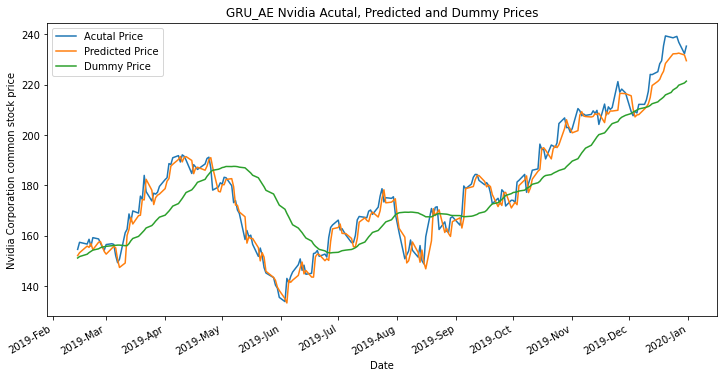

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

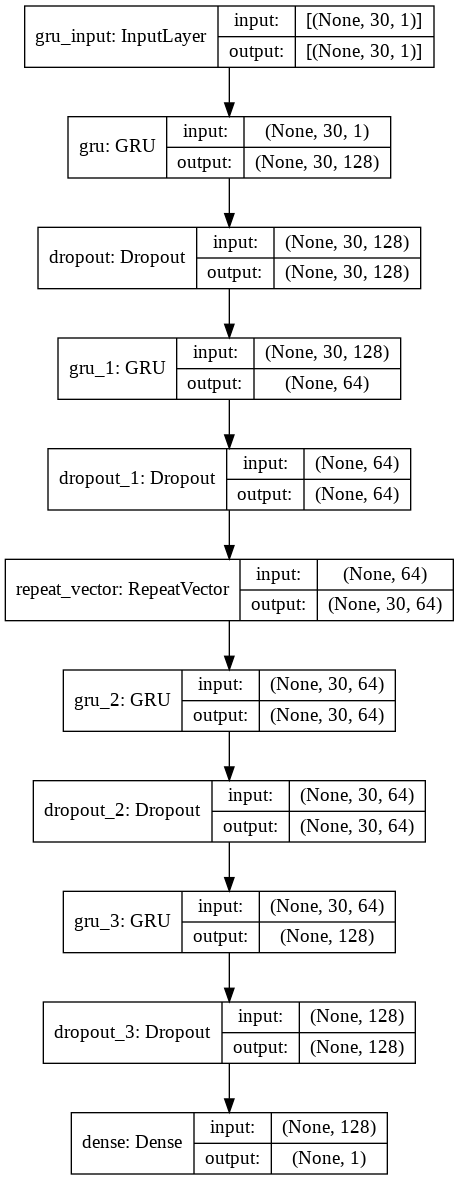

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0018939809312916171
RMSE:  0.043519891214151916
MAE:  0.03418236423365827
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Nvidia/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Nvidia/assets
